<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex3_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3: Neural Network Based Correction

This final exercise shows how to use neural networks in Python to model gradient distortions. As you will see, this requires more effort than our previous linear corrections, so is probably most ideal for systems with pronounced distortions or on which the user desires to use extremely demanding gradient waveforms.

See the following reference:

1.   Martin JB, Alderson HE, Gore JC, Does MD, Harkins KD. Improved Image Reconstruction and Diffusion Parameter Estimation Using a Temporal Convolutional Network Model of Gradient Trajectory Errors. [preprint]. 2025 June. Available from: https://arxiv.org/abs/2506.14995. doi: 10.48550/arXiv.2506.14995.

Google Colab gives us access to a GPU - let's make sure we use it! Prior to running this notebook, make sure you are in a GPU runtime by navigating from the top toolbar **Runtime -> Change Runtime Type**, and selecting **T4 GPU**.



First, we'll add the utility and data files, which contain some training functions and the scanner data, to our local runtime via git:

In [2]:
!git clone https://github.com/jonbmartin/Gradient-Waveform-Errors-Demos

Cloning into 'Gradient-Waveform-Errors-Demos'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 184 (delta 4), reused 0 (delta 0), pack-reused 172 (from 1)
Receiving objects: 100% (184/184), 14.32 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [3]:
import sys
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos')
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos/utils/')

In [4]:
import random
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data

from belief_network_util import *
from custom_environments_belief import *


In [5]:
# data paths:
data = sio.loadmat('Gradient-Waveform-Errors-Demos/data/all_ideal_waveforms_normalized.mat')
g_ideal_m = np.squeeze(data['ideal'])
file = 'Gradient-Waveform-Errors-Demos/data/scanner_data_augmented_amp_feature_normalized.csv'


In [6]:
##############################################
# Training to initialize the belief network  #
##############################################
return_traj_y = False
input_size = 3 # (2 states and 1 action) - just gideal amplitude, precomp amp, action. Could be expanded to include other features of interest.
n_epochs = 5


# set up which device we will be using
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device to be used = {device}')

# set up our TCN model! optimized hyperparameters:
channel_sizes = [48] * 5 # temporal causal layer channels
kernel_size = 16 # convolution kernel size
dropout = 0.002
batch_size = 32
lr = 8.4E-04
weight_decay = 8.7E-08
eps = 4.24E-06
beta1 = 0.9
beta2 = 0.999999
window_size = 75
predict_point = 65

model_params = {
    'input_size':   input_size,
    'output_size':  1,
    'num_channels': channel_sizes,
    'kernel_size':  kernel_size,
    'dropout':      dropout
}
belief_model = TCN(**model_params)

obs_space = 5
act_space = 1
belief_training_buffer = BeliefWindowBuffer(obs_space, act_space,
                                    buffer_length=int(50_000))


Device to be used = cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Ok, next let's actually train this network! It will take a few minutes (<5) to train the network for 5 epochs on the T4 GPU.

loading training/testing data from: Gradient-Waveform-Errors-Demos/data/scanner_data_augmented_amp_feature_normalized.csv


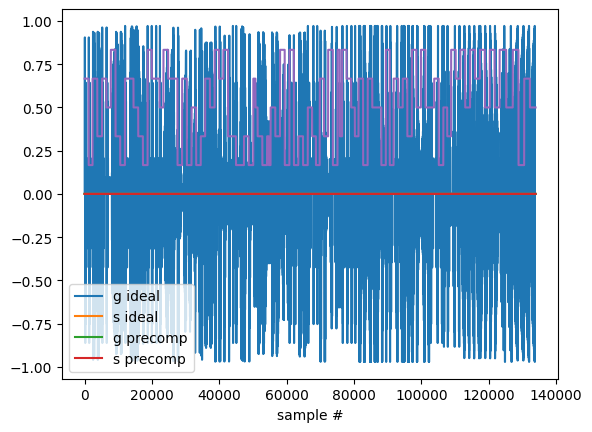

Status: Pretraining the belief model
Train size = 107142
range(0, 107067)
range(0, 26711)
size of x train data = torch.Size([107067, 3, 75])
size of y train data = torch.Size([107067, 1])
size of x test data = torch.Size([26711, 3, 75])
size of y test data = torch.Size([26711, 1])
Training and testing belief network
torch.Size([107067, 3, 75])


/content/Gradient-Waveform-Errors-Demos/utils/belief_network_util.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/content/Gradient-Waveform-Errors-Demos/utils/belief_network_util.py:144: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


New best test cost: 
Epoch 0: train cost 4.62E-03, test cost 4.79E-03
New best test cost: 
Epoch 1: train cost 4.35E-03, test cost 4.60E-03
Epoch 2: train cost 4.17E-03, test cost 6.40E-03
Epoch 3: train cost 4.02E-03, test cost 4.62E-03
Epoch 4: train cost 3.89E-03, test cost 5.91E-03


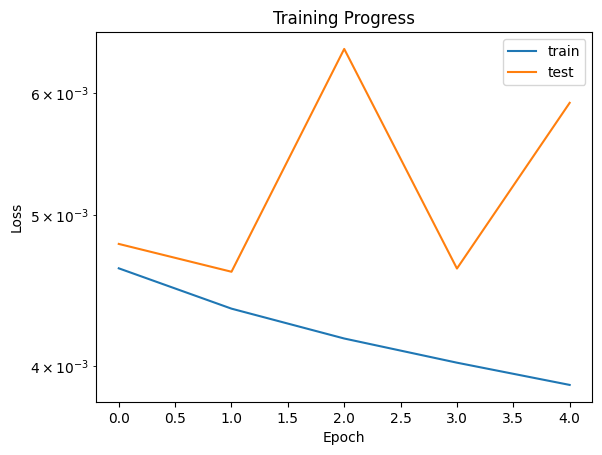

In [12]:
# Loading the NORMALIZED data with feature scale
print('loading training/testing data from: '+ file)
belief_training_buffer.add_transitions_from_csv(file)
collected_observations = belief_training_buffer.get_observation_v_array()

feature_indices = [0, 4] # input grad amp and waveform scale
scale_factors = np.squeeze(collected_observations[:,4]) # normalized scale factors
max_scale_mt_m = 275 # [mT/m], the normalizing max amplitude

plt.plot(collected_observations)
plt.legend(['g ideal', 's ideal', 'g precomp', 's precomp'])
plt.xlabel('sample #')
plt.show()

data_normalized_flag = True

print("Status: Pretraining the belief model")
train_test_split = 0.8
train_size = int(len(belief_training_buffer.observed_error_v) * train_test_split)
print(f'Train size = {train_size}' )
X_train, X_test, y_train, y_test = belief_training_buffer.return_X_Y_train_test(train_test_split=train_test_split,
                                          normalize=not data_normalized_flag, rl_env=None,
                                          feature_indices=feature_indices)

X_train, y_train = create_dataset(X_train, y_train, window_size=window_size, predict_point=predict_point,
                                  predict_single_timepoint=True,
                                  pct_data_to_keep=1, return_traj_y=return_traj_y)
X_test, y_test = create_dataset(X_test, y_test, window_size=window_size, predict_point=predict_point,
                                predict_single_timepoint=True,
                                pct_data_to_keep=1, return_traj_y=return_traj_y)

X_train = X_train.transpose(1, 2)
X_test = X_test.transpose(1, 2)

# should be: [number of examples, data dimension, timeseries length]
print(f'size of x train data = {X_train.size()}')
print(f'size of y train data = {y_train.size()}')
print(f'size of x test data = {X_test.size()}')
print(f'size of y test data = {y_test.size()}')

optimizer = optim.Adam(belief_model.parameters(),betas=(beta1, beta2), eps=eps,
                        lr=lr, weight_decay=weight_decay)
loss_fn = nn.L1Loss()

X_train = X_train.to(device)
y_train = y_train.to(device)
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

belief_model, test_cost, best_params = train_and_test_belief_network(n_epochs, belief_model, loss_fn, optimizer, loader,
                                        X_train, X_test, y_train, y_test, device=device)

# a little cleanup
del X_train, X_test, y_train, y_test, loader
torch.cuda.empty_cache()

In [15]:
print("Status: Evaluating the model on test dataset")

_, X_test, _, y_test = belief_training_buffer.return_X_Y_train_test(train_test_split=train_test_split, normalize=not data_normalized_flag,
    rl_env=None, feature_indices=feature_indices)

X_test, y_test = create_dataset(X_test, y_test, window_size=window_size, predict_point=predict_point,
                                predict_single_timepoint=True,
                                pct_data_to_keep=1, return_traj_y=return_traj_y)
X_test = X_test.transpose(1, 2)
X_test = X_test.to(device)

belief_model.eval()
with torch.no_grad():
    observed_error_v = torch.tensor(belief_training_buffer.observed_error_v)[:,None]

    # shift test predictions for plotting
    test_plot = torch.ones_like(observed_error_v) * 0
    output = belief_model(X_test)
    test_plot[train_size+window_size:len(observed_error_v)] = output
    test_plot = np.squeeze(np.roll(test_plot,predict_point-window_size))

Status: Evaluating the model on test dataset
range(0, 26711)


Status: Plotting a sample waveform


/tmp/ipython-input-16-3228129018.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  observed_error_mTm = np.squeeze(observed_error_v)*scale_factors*max_scale_mt_m


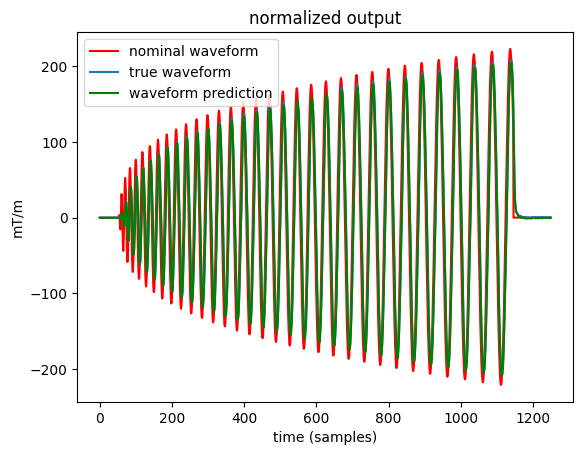

/tmp/ipython-input-16-3228129018.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(observed_error_mTm[min_idx:max_idx]-nominal_waveform_mTm[min_idx:max_idx], c='r')
/tmp/ipython-input-16-3228129018.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(observed_error_mTm[min_idx:max_idx]-test_plot_mTm[min_idx:max_idx], c='g')


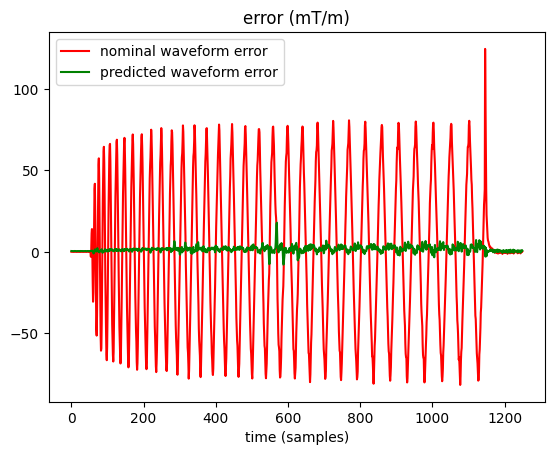

In [16]:
print("Status: Plotting a sample waveform")

# pick a particular section of our data that we'd like to plot:
min_idx = 127_500
max_idx = 128_750

nominal_waveform_mTm = np.squeeze(collected_observations[:,0])*scale_factors*max_scale_mt_m
observed_error_mTm = np.squeeze(observed_error_v)*scale_factors*max_scale_mt_m
test_plot_mTm = np.squeeze(test_plot)*scale_factors*max_scale_mt_m

plt.plot(nominal_waveform_mTm[min_idx:max_idx], c='r')
plt.plot(observed_error_mTm[min_idx:max_idx])
plt.plot(test_plot_mTm[min_idx:max_idx], c='g')
plt.title('normalized output')
plt.ylabel('mT/m')
plt.xlabel('time (samples)')
plt.legend(['nominal waveform','true waveform','waveform prediction'])
plt.show()

plt.plot(observed_error_mTm[min_idx:max_idx]-nominal_waveform_mTm[min_idx:max_idx], c='r')
plt.plot(observed_error_mTm[min_idx:max_idx]-test_plot_mTm[min_idx:max_idx], c='g')
plt.title('error (mT/m)')
plt.xlabel('time (samples)')
plt.legend(['nominal waveform error','predicted waveform error'])
plt.show()
